In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
from datetime import datetime, timedelta

In [4]:
# Initialize Faker
fake = Faker()

# Set random seed for reproducibility
np.random.seed(None)
Faker.seed(None)

In [5]:
# 1. Create users dataset (id, name, date_of_birth)
num_users = 1000
users = []
user_ids = [fake.uuid4() for _ in range(num_users)]

# Define the visit year range
visit_year = 2023

for user_id in user_ids:
    # Generate random age between 0 and 90 at the time of visit
    age_at_visit = np.random.randint(0, 91)  # 0 to 90 years old
    
    # Calculate date of birth range to ensure correct age at visit
    max_dob = pd.Timestamp(year=visit_year - age_at_visit, month=12, day=31)
    min_dob = pd.Timestamp(year=visit_year - age_at_visit - 1, month=1, day=1)
    
    # Generate a random date within the calculated year
    dob = fake.date_between_dates(min_dob, max_dob)
    
    users.append({
        'id': user_id,
        'name': fake.name(),
        'date_of_birth': dob
    })

users_df = pd.DataFrame(users)

In [6]:
# 2. Create visits dataset (year, month, user_id)
visits = []
start_date = datetime(visit_year, 1, 1)
end_date = datetime(visit_year, 12, 31)

for _ in range(5000):  # 5000 visits in total
    # Random date within visit_year
    random_days = np.random.randint(0, (end_date - start_date).days + 1)
    visit_date = start_date + timedelta(days=random_days)
    
    # Random user
    user_id = np.random.choice(user_ids)
    
    visits.append({
        'year': visit_date.year,
        'month': visit_date.month,
        'user_id': user_id,
        'visit_date': visit_date.strftime('%Y-%m-%d')
    })

visits_df = pd.DataFrame(visits)

In [7]:
# 3. Merge datasets and calculate age at visit time
merged_df = pd.merge(visits_df, users_df, left_on='user_id', right_on='id')
merged_df['date_of_birth'] = pd.to_datetime(merged_df['date_of_birth'])
merged_df['visit_date'] = pd.to_datetime(merged_df['visit_date'])
merged_df['age'] = (merged_df['visit_date'] - merged_df['date_of_birth']).dt.days // 365

In [8]:
# 4. Create age groups
bins = [0, 14, 18, 30, 40, 50, 60, 70, 80, 90]
labels = ['0-13', '14-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

In [9]:
# 5. Group by month and age group, then count visits
monthly_age_visits = merged_df.groupby(['month', 'age_group'], observed=False).size().unstack(fill_value=0)

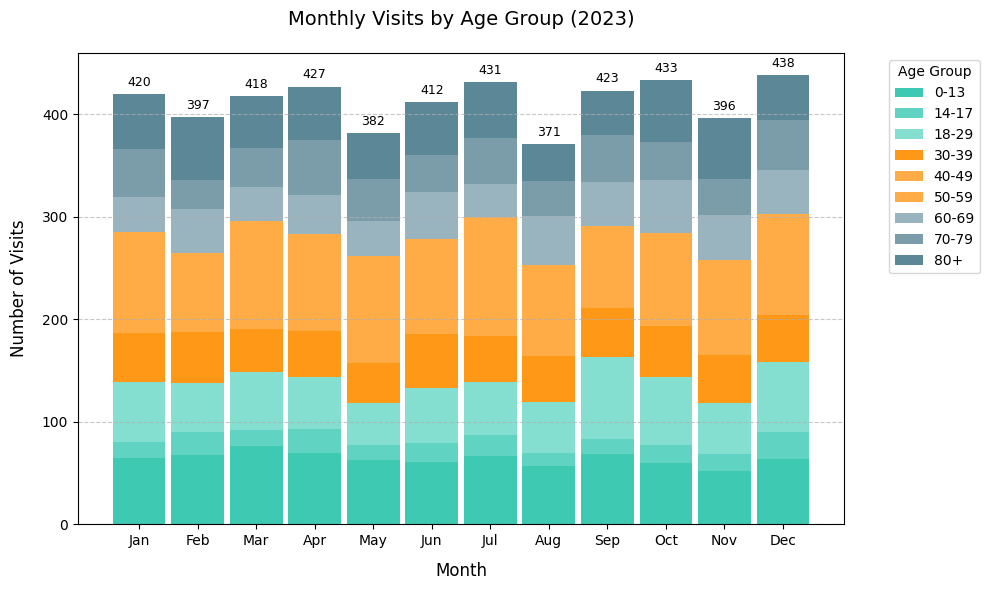

In [20]:
# 6. Create stacked bar chart
colors = ['#3EC9B2', '#61D3C2', '#84DFD1', '#FF9816', '#FFAC47', '#FFAC47', '#99B4BF', '#7B9DAA', '#5B8797']

# Plot stacked bars
plt.figure(figsize=(10, 6))  # define figure size first

bottom = np.zeros(len(monthly_age_visits.index))
for i, age_group in enumerate(monthly_age_visits.columns):
    plt.bar(
        monthly_age_visits.index, 
        monthly_age_visits[age_group], 
        bottom=bottom,
        label=age_group,
        color=colors[i % len(colors)],
        width=0.9
    )
    bottom += monthly_age_visits[age_group].values

# Customize the plot
plt.title(f'Monthly Visits by Age Group ({visit_year})', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12, labelpad=10)
plt.ylabel('Number of Visits', fontsize=12, labelpad=10)
plt.xticks(monthly_age_visits.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
total_visits = monthly_age_visits.sum(axis=1)
for i, month in enumerate(monthly_age_visits.index):
    plt.text(month, total_visits[month] + 5, str(total_visits[month]),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Show sample data
print("Sample Users Data:")
display(users_df)
print("Sample Visits Data:")
display(visits_df)

Sample Users Data:


,id,name,date_of_birth
0,d537630d-5d6c-44f1-bb03-624aaa89d3f0,Jennifer Lawrence,1965-03-16
1,4dd1cac8-354a-4f56-851c-899cb5f44bcd,Linda Gordon,1968-09-24
2,1069f679-ed10-430c-98c9-b894d2ed03fb,Ethan Freeman,1941-06-14
3,230a01df-7e6a-4c86-b6d9-34408a6c43ec,Jennifer Olson,1958-08-23
4,83174a10-8f57-4349-98a4-f54a61d84a15,Robert Wyatt,1947-08-20
...,...,...,...
995,dc3a18ff-9fa7-48e2-a9d8-5e9a8a2c3ad9,Sierra Rhodes,2011-11-11
996,5c770254-d8d6-49e4-9382-4b5723a9af54,Kathleen Bowers,1958-11-06
997,74c8b399-8df0-4e0c-8b72-09d822054206,Edward Christian,1947-08-27
998,c22aa331-6e72-4995-be55-029edfb06e0f,Alexander Barton,1989-07-03


Sample Visits Data:


,year,month,user_id,visit_date
0,2023,7,92028e40-05d7-4b08-bebf-e2e53c9adfcc,2023-07-18
1,2023,12,23ff9c76-6941-4670-97ec-49cd816445a7,2023-12-13
2,2023,7,23ff9c76-6941-4670-97ec-49cd816445a7,2023-07-26
3,2023,11,c8cdf0d9-24a9-477b-a857-adf4569c7a32,2023-11-24
4,2023,5,e6722274-5191-4a4c-a547-25a54a254a48,2023-05-31
...,...,...,...,...
4995,2023,6,be51816b-0ad6-4667-8f39-28b07460ece4,2023-06-14
4996,2023,6,8ad01d1b-1296-4004-a1a8-f4543cab5998,2023-06-24
4997,2023,10,079df1c9-d19e-487a-a205-8ff1f19d1d1e,2023-10-18
4998,2023,12,fbeb55ab-ca38-4ea5-a0ea-42ec800b9b74,2023-12-27
